# Classifying Members of *Ursidae* with Convolutional Neural Networks

**Goal:** To correctly identify the species of bear given an image of a grizzly, panda, or polar bear 

**Data Source:** Bing Image Search

**Data Input:** Images of grizzly, panda, and polar bears

**Output:** Output label for species of bear

### 1. Load In Data

Upload data.zip that contains the input images, sorted into labeled folders.

In [ ]:
!ls -lh

total 4.0K
drwxr-xr-x 1 root root 4.0K Apr 21 13:39 sample_data


In [ ]:
!gdown https://drive.google.com/uc?id=1NiOQoOYciSXMD63EBDrb2fPUKRayQgDL

Downloading...
From: https://drive.google.com/uc?id=1NiOQoOYciSXMD63EBDrb2fPUKRayQgDL
To: /content/bears.zip
472MB [00:03, 128MB/s]


In [ ]:
!ls -lh

total 450M
-rw-r--r-- 1 root root 450M May  7 01:32 bears.zip
drwxr-xr-x 1 root root 4.0K Apr 21 13:39 sample_data


In [ ]:
! unzip -q bears.zip

In [ ]:
! rm -r sample_data
! ls 

bears  bears.zip


### 2. Data Visualization

Show a few representative images.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_generator = ImageDataGenerator(rescale=1./255)

training_data = image_generator.flow_from_directory( 'bears/training', target_size=(256, 256), batch_size=9, class_mode='categorical')
print(training_data.image_shape)

Found 727 images belonging to 3 classes.
(256, 256, 3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

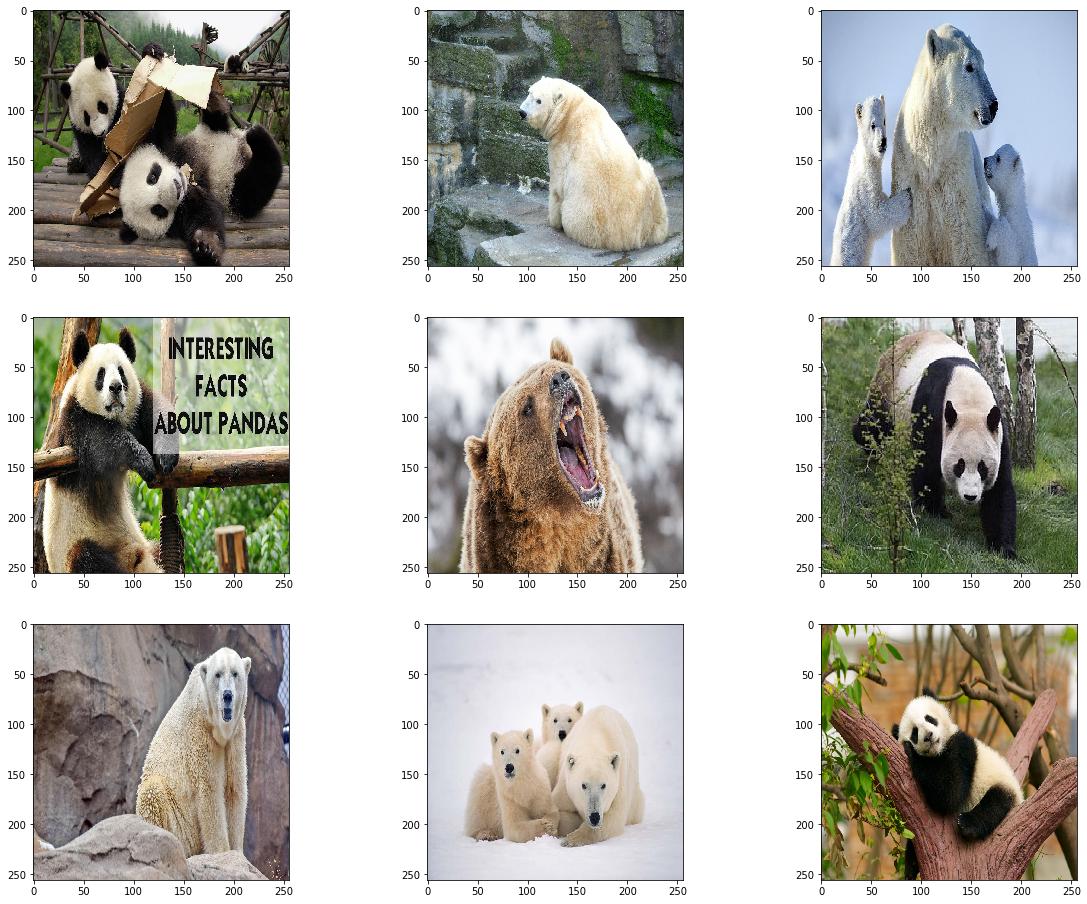

In [ ]:
L = 3
plt.figure(figsize=(20,16))
for my_batch in training_data:
  images = my_batch[0]
  labels = my_batch[1]
  for r in range(0,3):
    for c in range(0,3):
      plt.subplot(L,L,r * L + c + 1)
      #plt.axis('off')
      #plt.title(labels[r * L + c])
      plt.imshow(images[r * L + c])
  break

### 3. Model Overfitting

Using all the data, we create a model that reaches close to 100% accuracy. Although we don't want to split the data at this point, we also need to ensure our results are consistent from run to run. For replicability, we will download another file that contains all images from our dataset, randomly sorted into validation and training folders. This random sort is independent of the random sort used to split the dataset that will actually be used for developing the CNN.

In [ ]:
!gdown https://drive.google.com/uc?id=1axU8tROnd8H1snOh_nZhtYPjHGICDS7T

Downloading...
From: https://drive.google.com/uc?id=1axU8tROnd8H1snOh_nZhtYPjHGICDS7T
To: /content/bears_overfit.zip
472MB [00:06, 69.4MB/s]


In [ ]:
!ls -lh

total 900M
drwxr-xr-x 5 root root 4.0K Apr 15 13:07 bears
-rw-r--r-- 1 root root 450M Apr 15 17:43 bears_overfit.zip
-rw-r--r-- 1 root root 450M Apr 15 17:42 bears.zip


In [ ]:
!unzip -q bears_overfit.zip

In [ ]:
!ls -lh

total 900M
drwxr-xr-x 5 root root 4.0K Apr 15 13:07 bears
-rw-r--r-- 1 root root 450M Apr 15 17:43 bears_overfit.zip
-rw-r--r-- 1 root root 450M Apr 15 17:42 bears.zip
drwxr-xr-x 4 root root 4.0K Mar 25 16:01 overfit


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
all_data = ImageDataGenerator(rescale=1./255)
overfit_train = all_data.flow_from_directory( 'overfit/training', target_size=(256, 256), batch_size=16, class_mode='categorical')
overfit_valid = all_data.flow_from_directory( 'overfit/validation', target_size=(256, 256), batch_size=16, class_mode='categorical')

##For conversion to grayscale:
#color_mode='grayscale',

Found 972 images belonging to 3 classes.
Found 241 images belonging to 3 classes.


In [ ]:
print(overfit_train.image_shape)
print(overfit_train.n)

print(overfit_valid.image_shape)
print(overfit_valid.n)

(256, 256, 3)
972
(256, 256, 3)
241


To overfit, we will attempt to over-inflate the number of parameters our model needs as the greater the number of parameters, the more likely the model will fit itself directly to the data.

**Overfit Model 1:**



*   3 convolutional layers with 64, 32, and 16 kernels
*   1 MaxPool with 5x5 filter
*   4 dense layers with 40, 20, 10 and 3 kernels



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam, Adamax

In [ ]:
overfit_model_1 = Sequential()
overfit_model_1.add( Conv2D(filters=64, kernel_size=5, activation = 'relu', input_shape = overfit_train.image_shape ) )
overfit_model_1.add( Conv2D(filters=32, kernel_size=5, activation = 'relu' ) )
overfit_model_1.add( Conv2D(filters=16, kernel_size=5, activation = 'relu' ) )
overfit_model_1.add( MaxPool2D(5,5))
overfit_model_1.add( Flatten())
overfit_model_1.add( Dense(units=40, activation = 'relu' ) )
overfit_model_1.add( Dense(units=20, activation = 'relu' ) )
overfit_model_1.add( Dense(units=10, activation = 'relu' ) )
overfit_model_1.add( Dense(units=3, activation = 'softmax' ) )

overfit_model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 64)      4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 248, 248, 32)      51232     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 244, 244, 16)      12816     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 40)                1474600   
_________________________________________________________________
dense_1 (Dense)              (None, 20)                8

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
overfit_model_1.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
history1 = overfit_model_1.fit( overfit_train, validation_data = overfit_valid, epochs = 100, batch_size = 64 )

Epoch 1/100
61/61 [==============================] - 70s 585ms/step - loss: 1.0836 - accuracy: 0.4398 - precision: 0.5835 - recall: 0.0711 - val_loss: 0.8315 - val_accuracy: 0.6349 - val_precision: 0.7565 - val_recall: 0.3610
Epoch 2/100
61/61 [==============================] - 33s 539ms/step - loss: 0.7675 - accuracy: 0.7163 - precision: 0.7762 - recall: 0.4499 - val_loss: 0.7449 - val_accuracy: 0.7469 - val_precision: 0.7951 - val_recall: 0.4025
Epoch 3/100
61/61 [==============================] - 33s 541ms/step - loss: 0.6091 - accuracy: 0.7985 - precision: 0.8431 - recall: 0.6520 - val_loss: 0.9706 - val_accuracy: 0.5851 - val_precision: 0.6199 - val_recall: 0.5685
Epoch 4/100
61/61 [==============================] - 33s 535ms/step - loss: 0.2821 - accuracy: 0.9201 - precision: 0.9258 - recall: 0.8888 - val_loss: 0.5450 - val_accuracy: 0.8174 - val_precision: 0.8376 - val_recall: 0.8133
Epoch 5/100
61/61 [==============================] - 32s 533ms/step - loss: 0.0994 - accuracy: 0

Plot learning curves

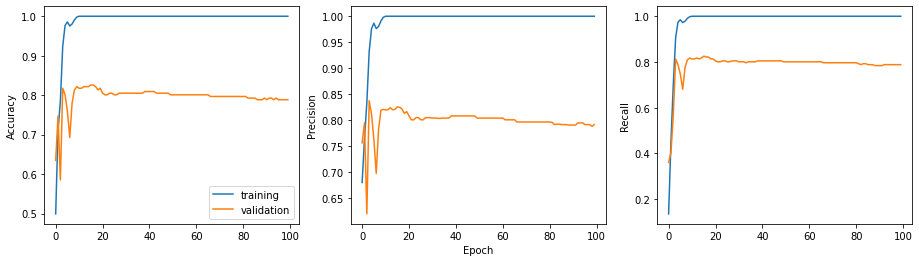

In [ ]:
plt.subplots_adjust(right=2.1, left=.09)

plt.subplot(1,3,1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(history1.history['precision'])
plt.plot(history1.history['val_precision'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
#plt.legend(['training','validation'], loc="lower right")


plt.subplot(1,3,3)
plt.plot(history1.history['recall'])
plt.plot(history1.history['val_recall'])
plt.ylabel('Recall')
plt.xlabel('')
#plt.legend(['training','validation'], loc="lower right")

plt.show()

**Overfit Model 2:**


*   7 convolutional layer with 64, 32 (x5), and 16 kernels
*   1 MaxPool with 5x5 filter
*   5 dense layers with 80, 40, 20, 10, and 3 kernels



In [ ]:
overfit_model_2 = Sequential()
overfit_model_2.add( Conv2D(filters=64, kernel_size=3, activation = 'relu', input_shape = overfit_train.image_shape ) )
for i in range(6):
  overfit_model_2.add( Conv2D(filters=32, kernel_size=3, activation = 'relu' ) )
overfit_model_2.add( Conv2D(filters=16, kernel_size=3, activation = 'relu' ) )
overfit_model_2.add( MaxPool2D(5,5))
overfit_model_2.add( Flatten())
overfit_model_2.add( Dense(units=80, activation = 'relu' ) )
overfit_model_2.add( Dense(units=40, activation = 'relu' ) )
overfit_model_2.add( Dense(units=20, activation = 'relu' ) )
overfit_model_2.add( Dense(units=10, activation = 'relu' ) )
overfit_model_2.add( Dense(units=3, activation = 'softmax' ) )

overfit_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 252, 252, 32)      18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 250, 250, 32)      9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 248, 248, 32)      9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 246, 246, 32)      9248      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 244, 244, 32)      9248      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 242, 242, 32)     

In [ ]:
overfit_model_2.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
history2 = overfit_model_2.fit( overfit_train, validation_data = overfit_valid, epochs = 50, batch_size = 64 )

Epoch 1/50
61/61 [==============================] - 44s 644ms/step - loss: 1.0032 - accuracy: 0.4756 - precision_1: 0.7077 - recall_1: 0.1934 - val_loss: 0.6647 - val_accuracy: 0.7261 - val_precision_1: 0.8053 - val_recall_1: 0.6349
Epoch 2/50
61/61 [==============================] - 34s 567ms/step - loss: 0.6619 - accuracy: 0.7190 - precision_1: 0.7878 - recall_1: 0.6507 - val_loss: 0.5632 - val_accuracy: 0.7469 - val_precision_1: 0.7955 - val_recall_1: 0.7261
Epoch 3/50
61/61 [==============================] - 35s 573ms/step - loss: 0.5447 - accuracy: 0.8054 - precision_1: 0.8188 - recall_1: 0.7651 - val_loss: 0.5314 - val_accuracy: 0.7842 - val_precision_1: 0.7949 - val_recall_1: 0.7718
Epoch 4/50
61/61 [==============================] - 35s 565ms/step - loss: 0.5080 - accuracy: 0.7988 - precision_1: 0.8169 - recall_1: 0.7683 - val_loss: 0.5000 - val_accuracy: 0.8174 - val_precision_1: 0.8405 - val_recall_1: 0.8091
Epoch 5/50
61/61 [==============================] - 35s 573ms/step -

Plot learning curves.

In [ ]:
plt.subplots_adjust(right=2.1, left=.09)
plt.subplot(1,3,1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(history2.history['precision_1'])
plt.plot(history2.history['val_precision_1'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
#plt.legend(['training','validation'], loc="lower right")


plt.subplot(1,3,3)
plt.plot(history2.history['recall_1'])
plt.plot(history2.history['val_recall_1'])
plt.ylabel('Recall')
plt.xlabel('')
#plt.legend(['training','validation'], loc="lower right")

plt.show()

**Overfit Model 3:**


*   3 convolutional layers with 128, 64, and 32 kernels
*   1 MaxPool with 5x5 filter
*   4 dense layers with 120, 60, 30 and 3 kernels

In [ ]:
overfit_model_3 = Sequential()
overfit_model_3.add( Conv2D(filters=128, kernel_size=3, activation = 'relu', input_shape = overfit_train.image_shape ) )
overfit_model_3.add( Conv2D(filters=64, kernel_size=3, activation = 'relu' ) )
overfit_model_3.add( Conv2D(filters=32, kernel_size=3, activation = 'relu' ) )
overfit_model_3.add( MaxPool2D(5,5))
overfit_model_3.add( Flatten())
overfit_model_3.add( Dense(units=120, activation = 'relu' ) )
overfit_model_3.add( Dense(units=60, activation = 'relu' ) )
overfit_model_3.add( Dense(units=30, activation = 'relu' ) )
overfit_model_3.add( Dense(units=3, activation = 'softmax' ) )

overfit_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 254, 254, 128)     3584      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 252, 252, 64)      73792     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 250, 250, 32)      18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               9600120   
_________________________________________________________________
dense_10 (Dense)             (None, 60)               

In [ ]:
overfit_model_3.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
history3 = overfit_model_3.fit( overfit_train, validation_data = overfit_valid, epochs = 50, batch_size = 64 )


Epoch 1/50
61/61 [==============================] - 40s 605ms/step - loss: 1.3261 - accuracy: 0.3675 - precision_2: 0.3346 - recall_2: 0.0561 - val_loss: 0.8507 - val_accuracy: 0.6805 - val_precision_2: 0.7143 - val_recall_2: 0.3320
Epoch 2/50
61/61 [==============================] - 33s 543ms/step - loss: 0.7976 - accuracy: 0.7060 - precision_2: 0.7019 - recall_2: 0.4235 - val_loss: 0.6444 - val_accuracy: 0.7427 - val_precision_2: 0.7877 - val_recall_2: 0.6929
Epoch 3/50
61/61 [==============================] - 33s 541ms/step - loss: 0.4482 - accuracy: 0.8596 - precision_2: 0.8833 - recall_2: 0.8169 - val_loss: 0.4036 - val_accuracy: 0.8631 - val_precision_2: 0.8809 - val_recall_2: 0.8589
Epoch 4/50
61/61 [==============================] - 33s 537ms/step - loss: 0.1534 - accuracy: 0.9492 - precision_2: 0.9538 - recall_2: 0.9426 - val_loss: 0.4355 - val_accuracy: 0.8589 - val_precision_2: 0.8734 - val_recall_2: 0.8589
Epoch 5/50
61/61 [==============================] - 33s 547ms/step -

Plot learning curves

In [ ]:
plt.subplots_adjust(right=2.1, left=.09)

plt.subplot(1,3,1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(history3.history['precision_2'])
plt.plot(history3.history['val_precision_2'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
#plt.legend(['training','validation'], loc="lower right")


plt.subplot(1,3,3)
plt.plot(history3.history['recall_2'])
plt.plot(history3.history['val_recall_2'])
plt.ylabel('Recall')
plt.xlabel('')
#plt.legend(['training','validation'], loc="lower right")

plt.show()

### 4. Training a Fitted Model

Now that we know our model can be over-trained, we will focus on building a model that can be trained well. 

In [ ]:
validation_data = image_generator.flow_from_directory( 'bears/validation', target_size=(256, 256), batch_size=9, class_mode='categorical')
testing_data = image_generator.flow_from_directory( 'bears/test', target_size=(256, 256), batch_size=9, class_mode='categorical')


Found 243 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
callback_earlystp = EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1)

After multiple experiments, a model with the following structure appeared to be the most effective model:

*   3 convolutional layers with 16, 8 and 4 kernals, each using a relu activation function
*   3 MaxPools that follow each of the convolutional layers
*   2 dense layers with 5 and 3 neurons using a relu and softmax activation function, respectively


In [ ]:
model_1 = Sequential()
model_1.add( Conv2D(filters=16, kernel_size=3, activation = 'relu', input_shape = training_data.image_shape ) )
model_1.add( MaxPool2D(5,5)) 
model_1.add( Conv2D(filters=8, kernel_size=3, activation = 'relu' ) )
model_1.add( MaxPool2D(5,5))
model_1.add( Conv2D(filters=4, kernel_size=3, activation = 'relu' ) )
model_1.add( MaxPool2D(5,5))
model_1.add( Flatten())
model_1.add( Dense(units=5, activation = 'relu' ) )
model_1.add( Dense(units=3, activation = 'softmax' ) )

model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 8)         1160      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 9, 9, 8)           0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 1, 4)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4)                

In [ ]:
model_1.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
fit_history_1 = model_1.fit( training_data, validation_data = validation_data, epochs = 50, batch_size = 64, callbacks = [callback_earlystp] )

Epoch 1/50
81/81 [==============================] - 26s 312ms/step - loss: 1.0914 - accuracy: 0.4185 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 1.0588 - val_accuracy: 0.3539 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/50
81/81 [==============================] - 25s 303ms/step - loss: 1.0274 - accuracy: 0.4645 - precision_4: 0.5851 - recall_4: 0.0592 - val_loss: 1.0994 - val_accuracy: 0.3416 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 3/50
81/81 [==============================] - 24s 302ms/step - loss: 1.0824 - accuracy: 0.3303 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 1.0577 - val_accuracy: 0.3868 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 4/50
81/81 [==============================] - 25s 306ms/step - loss: 1.0072 - accuracy: 0.3792 - precision_4: 0.7278 - recall_4: 0.0739 - val_loss: 0.7923 - val_accuracy: 0.6008 - val_precision_4: 0.7255 - val_recall_4: 0.4568
Epoch 5/50
81/81 [==========

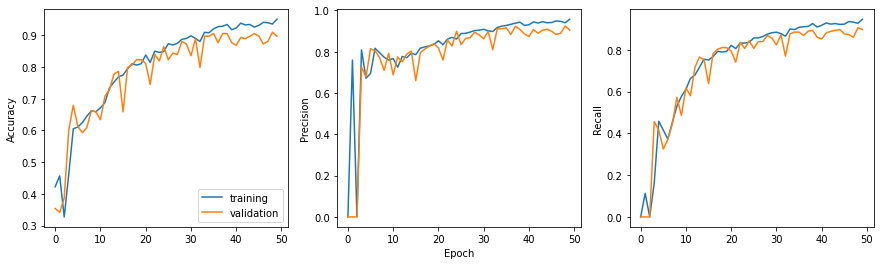

In [ ]:
plt.subplots_adjust(right=1.95, left=.03)

plt.subplot(1,3,1)
plt.plot(fit_history_1.history['accuracy'])
plt.plot(fit_history_1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(fit_history_1.history['precision_4'])
plt.plot(fit_history_1.history['val_precision_4'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
#plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,3)
plt.plot(fit_history_1.history['recall_4'])
plt.plot(fit_history_1.history['val_recall_4'])
plt.ylabel('Recall')
plt.xlabel('')
#plt.legend(['training','validation'], loc="lower right")

plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall = model_1.evaluate(testing_data)

print('%s %.2f' % ('validation_acc: ', test_acc*100.0 ))
print('%s %.2f' % ('validation_loss:', test_loss ))
print('%s %.2f' % ('validation_precision:', test_precision ))
print('%s %.2f' % ('validation_recall:', test_recall ))

27/27 [==============================] - 6s 218ms/step - loss: 0.3333 - accuracy: 0.8971 - precision_4: 0.9038 - recall_4: 0.8889
validation_acc:  89.71
validation_loss: 0.33
validation_precision: 0.90
validation_recall: 0.89


We will decrease the model by a few layers to see how performance changes.

In [ ]:
model_2 = Sequential()
model_2.add( Conv2D(filters=16, kernel_size=3, activation = 'relu', input_shape = training_data.image_shape ) )
model_2.add( MaxPool2D(5,5))
model_2.add( Conv2D(filters=8, kernel_size=3, activation = 'relu' ) )
model_2.add( MaxPool2D(5,5))
model_2.add( Conv2D(filters=4, kernel_size=3, activation = 'relu' ) )
model_2.add( MaxPool2D(5,5))
model_2.add( Flatten())
model_2.add( Dense(units=3, activation = 'softmax' ) )

model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 48, 48, 8)         1160      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 9, 8)           0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 1, 4)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4)                

In [ ]:
model_2.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
fit_history_2 = model_2.fit( training_data, validation_data = validation_data, epochs = 50, batch_size = 64, callbacks = [callback_earlystp] )

Epoch 1/50
81/81 [==============================] - 26s 316ms/step - loss: 1.1370 - accuracy: 0.3504 - precision_4: 0.3345 - recall_4: 0.0203 - val_loss: 1.0676 - val_accuracy: 0.3621 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/50
81/81 [==============================] - 25s 311ms/step - loss: 1.0568 - accuracy: 0.3808 - precision_4: 0.5812 - recall_4: 0.0097 - val_loss: 0.9732 - val_accuracy: 0.5309 - val_precision_4: 0.8293 - val_recall_4: 0.1399
Epoch 3/50
81/81 [==============================] - 25s 309ms/step - loss: 0.9826 - accuracy: 0.5365 - precision_4: 0.7863 - recall_4: 0.1665 - val_loss: 0.9174 - val_accuracy: 0.5556 - val_precision_4: 0.6762 - val_recall_4: 0.2922
Epoch 4/50
81/81 [==============================] - 25s 309ms/step - loss: 0.9213 - accuracy: 0.5754 - precision_4: 0.7375 - recall_4: 0.2234 - val_loss: 0.8478 - val_accuracy: 0.6132 - val_precision_4: 0.6045 - val_recall_4: 0.3333
Epoch 5/50
81/81 [==============================] - 25s 310m

In [ ]:
plt.subplots_adjust(right=1.95, left=.03)

plt.subplot(1,3,1)
plt.plot(fit_history_2.history['accuracy'])
plt.plot(fit_history_2.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(fit_history_2.history['precision_4'])
plt.plot(fit_history_2.history['val_precision_4'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
#plt.legend(['training','validation'], loc="lower right")


plt.subplot(1,3,3)
plt.plot(fit_history_2.history['recall_4'])
plt.plot(fit_history_2.history['val_recall_4'])
plt.ylabel('Recall')
plt.xlabel('')
#plt.legend(['training','validation'], loc="lower right")

plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall = model_2.evaluate(testing_data)

print('%s %.2f' % ('validation_acc: ', test_acc*100.0 ))
print('%s %.2f' % ('validation_loss:', test_loss ))
print('%s %.2f' % ('validation_precision:', test_precision ))
print('%s %.2f' % ('validation_recall:', test_recall ))

27/27 [==============================] - 6s 208ms/step - loss: 0.4525 - accuracy: 0.8519 - precision_4: 0.8638 - recall_4: 0.8354
validation_acc:  85.19
validation_loss: 0.45
validation_precision: 0.86
validation_recall: 0.84


We will now increase the number of layers and see performance.

In [ ]:
model_3 = Sequential()
model_3.add( Conv2D(filters=16, kernel_size=3, activation = 'relu', input_shape = training_data.image_shape ) )
model_3.add( MaxPool2D(5,5)) 
model_3.add( Conv2D(filters=8, kernel_size=3, activation = 'relu' ) )
model_3.add( MaxPool2D(5,5))
model_3.add( Conv2D(filters=4, kernel_size=3, activation = 'relu' ) )
model_3.add( MaxPool2D(5,5))
model_3.add( Flatten())
model_3.add( Dense(units=10, activation="relu"))
model_3.add( Dense(units=5, activation="relu"))
model_3.add( Dense(units=3, activation = 'softmax' ) )

model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 4)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0

In [ ]:
model_3.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
fit_history_3 = model_3.fit( training_data, validation_data = validation_data, epochs = 50, batch_size = 64, callbacks = [callback_earlystp] )

Epoch 1/50
81/81 [==============================] - 58s 317ms/step - loss: 1.0971 - accuracy: 0.3357 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0948 - val_accuracy: 0.3909 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
81/81 [==============================] - 25s 313ms/step - loss: 1.0929 - accuracy: 0.4337 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0832 - val_accuracy: 0.4527 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
81/81 [==============================] - 25s 311ms/step - loss: 1.0765 - accuracy: 0.4585 - precision: 0.3089 - recall: 0.0027 - val_loss: 1.0519 - val_accuracy: 0.3539 - val_precision: 1.0000 - val_recall: 0.0041
Epoch 4/50
81/81 [==============================] - 25s 310ms/step - loss: 1.0250 - accuracy: 0.4766 - precision: 0.6457 - recall: 0.0969 - val_loss: 0.9565 - val_accuracy: 0.5679 - val_precision: 0.9259 - val_recall: 0.2058
Epoch 5/50
81/81 [==============================] - 25s 309ms/step -

In [ ]:
plt.subplots_adjust(right=1.95, left=.03)

plt.subplot(1,3,1)
plt.plot(fit_history_3.history['accuracy'])
plt.plot(fit_history_3.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(fit_history_3.history['precision'])
plt.plot(fit_history_3.history['val_precision'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
#plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,3)
plt.plot(fit_history_3.history['recall'])
plt.plot(fit_history_3.history['val_recall'])
plt.ylabel('Recall')
plt.xlabel('')
#plt.legend(['training','validation'], loc="lower right")

plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall = model_3.evaluate(testing_data)

print('%s %.2f' % ('validation_acc: ', test_acc*100.0 ))
print('%s %.2f' % ('validation_loss:', test_loss ))
print('%s %.2f' % ('validation_precision:', test_precision ))
print('%s %.2f' % ('validation_recall:', test_recall ))

27/27 [==============================] - 6s 214ms/step - loss: 0.4167 - accuracy: 0.8971 - precision: 0.9008 - recall: 0.8971
validation_acc:  89.71
validation_loss: 0.42
validation_precision: 0.90
validation_recall: 0.90


We will now decrease the number of filters at each level and evaluate performance

In [ ]:
model_4 = Sequential()
model_4.add( Conv2D(filters=8, kernel_size=3, activation = 'relu', input_shape = training_data.image_shape ) )
model_4.add( MaxPool2D(5,5)) 
model_4.add( Conv2D(filters=4, kernel_size=3, activation = 'relu' ) )
model_4.add( MaxPool2D(5,5))
model_4.add( Conv2D(filters=2, kernel_size=3, activation = 'relu' ) )
model_4.add( MaxPool2D(5,5))
model_4.add( Flatten())
model_4.add( Dense(units=3, activation = 'relu' ) )
model_4.add( Dense(units=3, activation = 'softmax' ) )

model_4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 8)       224       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 4)         292       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 9, 4)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 2)           74        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 2)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2)                

In [ ]:
model_4.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
fit_history_4 = model_4.fit( training_data, validation_data = validation_data, epochs = 50, batch_size = 64, callbacks = [callback_earlystp] )

Epoch 1/50
81/81 [==============================] - 27s 320ms/step - loss: 1.1003 - accuracy: 0.2934 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.0982 - val_accuracy: 0.3086 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/50
81/81 [==============================] - 25s 308ms/step - loss: 1.0945 - accuracy: 0.3557 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.0989 - val_accuracy: 0.3086 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/50
81/81 [==============================] - 25s 306ms/step - loss: 1.0970 - accuracy: 0.3242 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.0985 - val_accuracy: 0.3086 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/50
81/81 [==============================] - 25s 306ms/step - loss: 1.0951 - accuracy: 0.3379 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.0753 - val_accuracy: 0.3086 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoc

In [ ]:
plt.subplots_adjust(right=1.95, left=.03)

plt.subplot(1,3,1)
plt.plot(fit_history_4.history['accuracy'])
plt.plot(fit_history_4.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(fit_history_4.history['precision_1'])
plt.plot(fit_history_4.history['val_precision_1'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
#plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,3)
plt.plot(fit_history_4.history['recall_1'])
plt.plot(fit_history_4.history['val_recall_1'])
plt.ylabel('Recall')
plt.xlabel('')
#plt.legend(['training','validation'], loc="lower right")

plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall = model_4.evaluate(testing_data)

print('%s %.2f' % ('validation_acc: ', test_acc*100.0 ))
print('%s %.2f' % ('validation_loss:', test_loss ))
print('%s %.2f' % ('validation_precision:', test_precision ))
print('%s %.2f' % ('validation_recall:', test_recall ))

27/27 [==============================] - 6s 209ms/step - loss: 0.7772 - accuracy: 0.6008 - precision_1: 0.8256 - recall_1: 0.2922
validation_acc:  60.08
validation_loss: 0.78
validation_precision: 0.83
validation_recall: 0.29


We will now increse the number of filters at each level and evaluate performance

In [ ]:
model_5 = Sequential()
model_5.add( Conv2D(filters=32, kernel_size=3, activation = 'relu', input_shape = training_data.image_shape ) )
model_5.add( MaxPool2D(5,5)) 
model_5.add( Conv2D(filters=16, kernel_size=3, activation = 'relu' ) )
model_5.add( MaxPool2D(5,5))
model_5.add( Conv2D(filters=8, kernel_size=3, activation = 'relu' ) )
model_5.add( MaxPool2D(5,5))
model_5.add( Flatten())
model_5.add( Dense(units=10, activation = 'relu' ) )
model_5.add( Dense(units=3, activation = 'softmax' ) )

model_5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 16)        4624      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 9, 16)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 1, 8)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8)                

In [ ]:
model_5.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
fit_history_5 = model_5.fit( training_data, validation_data = validation_data, epochs = 50, batch_size = 64, callbacks = [callback_earlystp] )

Epoch 1/50
81/81 [==============================] - 26s 309ms/step - loss: 1.1063 - accuracy: 0.3446 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.0898 - val_accuracy: 0.3416 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/50
81/81 [==============================] - 25s 304ms/step - loss: 1.0746 - accuracy: 0.4440 - precision_2: 0.3915 - recall_2: 0.0053 - val_loss: 0.9879 - val_accuracy: 0.5761 - val_precision_2: 0.7692 - val_recall_2: 0.0412
Epoch 3/50
81/81 [==============================] - 25s 304ms/step - loss: 0.8977 - accuracy: 0.6204 - precision_2: 0.7050 - recall_2: 0.2834 - val_loss: 0.6949 - val_accuracy: 0.7325 - val_precision_2: 0.7911 - val_recall_2: 0.5144
Epoch 4/50
81/81 [==============================] - 25s 306ms/step - loss: 0.6754 - accuracy: 0.6988 - precision_2: 0.7548 - recall_2: 0.5820 - val_loss: 0.6522 - val_accuracy: 0.6749 - val_precision_2: 0.7122 - val_recall_2: 0.6008
Epoch 5/50
81/81 [==============================] - 

In [ ]:
plt.subplots_adjust(right=1.95, left=.03)

plt.subplot(1,3,1)
plt.plot(fit_history_5.history['accuracy'])
plt.plot(fit_history_5.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(fit_history_5.history['precision_2'])
plt.plot(fit_history_5.history['val_precision_2'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
#plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,3)
plt.plot(fit_history_5.history['recall_2'])
plt.plot(fit_history_5.history['val_recall_2'])
plt.ylabel('Recall')
plt.xlabel('')
#plt.legend(['training','validation'], loc="lower right")

plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall = model_5.evaluate(testing_data)

print('%s %.2f' % ('validation_acc: ', test_acc*100.0 ))
print('%s %.2f' % ('validation_loss:', test_loss ))
print('%s %.2f' % ('validation_precision:', test_precision ))
print('%s %.2f' % ('validation_recall:', test_recall ))

27/27 [==============================] - 6s 211ms/step - loss: 0.4097 - accuracy: 0.8971 - precision_2: 0.8967 - recall_2: 0.8930
validation_acc:  89.71
validation_loss: 0.41
validation_precision: 0.90
validation_recall: 0.89


### 5. Model Augmentation

Now that we have found an optimal model, we will attempt to augment our data and evaluate its performance. 

In [ ]:
model_1 = Sequential()
model_1.add( Conv2D(filters=16, kernel_size=3, activation = 'relu', input_shape = augmented_training.image_shape ) )
model_1.add( MaxPool2D(5,5)) 
model_1.add( Conv2D(filters=8, kernel_size=3, activation = 'relu' ) )
model_1.add( MaxPool2D(5,5))
model_1.add( Conv2D(filters=4, kernel_size=3, activation = 'relu' ) )
model_1.add( MaxPool2D(5,5))
model_1.add( Flatten())
model_1.add( Dense(units=5, activation = 'relu' ) )
model_1.add( Dense(units=3, activation = 'softmax' ) )

model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 16)      160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 9, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 4)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4)                

**Augmentation 1**

We will first try to shift our images both left/right and up/down, as well as randomly flip some of them horizontally.

In [ ]:
augmented_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2)

In [ ]:
augmented_training = augmented_generator.flow_from_directory( 'bears/training', target_size=(256, 256), batch_size=9, class_mode='categorical')
augmented_validation = augmented_generator.flow_from_directory( 'bears/validation', target_size=(256, 256), batch_size=9, class_mode='categorical')
augmented_testing = augmented_generator.flow_from_directory( 'bears/test', target_size=(256, 256), batch_size=9, class_mode='categorical')

Found 727 images belonging to 3 classes.
Found 243 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [ ]:
L = 3
plt.figure(figsize=(20,16))
for my_batch in augmented_training:
  images = my_batch[0]
  labels = my_batch[1]
  for r in range(0,3):
    for c in range(0,3):
      plt.subplot(L,L,r * L + c + 1)
      plt.axis('off')
      #plt.title(labels[r * L + c])
      plt.imshow(images[r * L + c])
  break

In [ ]:
model_1.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
augmented_model_history = model_1.fit( augmented_training, validation_data = augmented_validation, epochs = 50, batch_size = 64, callbacks = [callback_earlystp] )

Epoch 1/50
81/81 [==============================] - 37s 447ms/step - loss: 1.0814 - accuracy: 0.3932 - precision_3: 0.3840 - recall_3: 0.0041 - val_loss: 1.0444 - val_accuracy: 0.4938 - val_precision_3: 0.7556 - val_recall_3: 0.1399
Epoch 2/50
81/81 [==============================] - 35s 436ms/step - loss: 1.0279 - accuracy: 0.5429 - precision_3: 0.7096 - recall_3: 0.1656 - val_loss: 0.9953 - val_accuracy: 0.4938 - val_precision_3: 0.6404 - val_recall_3: 0.2346
Epoch 3/50
81/81 [==============================] - 35s 430ms/step - loss: 0.9914 - accuracy: 0.5901 - precision_3: 0.6325 - recall_3: 0.1937 - val_loss: 0.9491 - val_accuracy: 0.5473 - val_precision_3: 0.6389 - val_recall_3: 0.2840
Epoch 4/50
81/81 [==============================] - 35s 440ms/step - loss: 0.9161 - accuracy: 0.6164 - precision_3: 0.7171 - recall_3: 0.2801 - val_loss: 0.9912 - val_accuracy: 0.5144 - val_precision_3: 0.5270 - val_recall_3: 0.3210
Epoch 5/50
81/81 [==============================] - 35s 435ms/step -

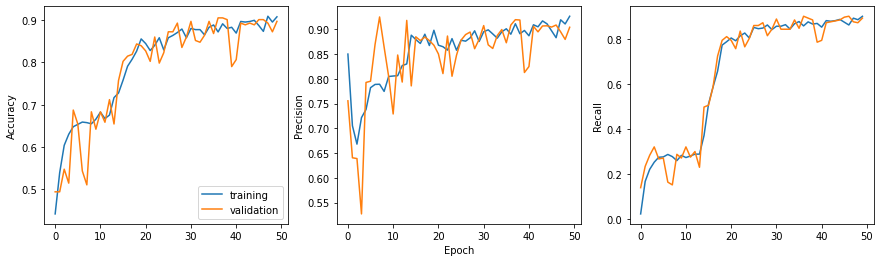

In [ ]:
plt.subplots_adjust(right=1.95, left=.03)

plt.subplot(1,3,1)
plt.plot(augmented_model_history.history['accuracy'])
plt.plot(augmented_model_history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(augmented_model_history.history['precision_3'])
plt.plot(augmented_model_history.history['val_precision_3'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
#plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,3)
plt.plot(augmented_model_history.history['recall_3'])
plt.plot(augmented_model_history.history['val_recall_3'])
plt.ylabel('Recall')
plt.xlabel('')
#plt.legend(['training','validation'], loc="lower right")

plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall = model_1.evaluate(augmented_testing)

print('%s %.2f' % ('validation_acc: ', test_acc*100.0 ))
print('%s %.2f' % ('validation_loss:', test_loss ))
print('%s %.2f' % ('validation_precision:', test_precision ))
print('%s %.2f' % ('validation_recall:', test_recall ))

27/27 [==============================] - 8s 316ms/step - loss: 0.3053 - accuracy: 0.9012 - precision_3: 0.9106 - recall_3: 0.8807
validation_acc:  90.12
validation_loss: 0.31
validation_precision: 0.91
validation_recall: 0.88


In [ ]:
del model_1

**Augmentation 2**

We will next add a zoom to our images. 

In [ ]:
augmented_generator = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2)

In [ ]:
augmented_training = augmented_generator.flow_from_directory( 'bears/training', target_size=(256, 256), batch_size=9, class_mode='categorical')
augmented_validation = augmented_generator.flow_from_directory( 'bears/validation', target_size=(256, 256), batch_size=9, class_mode='categorical')
augmented_testing = augmented_generator.flow_from_directory( 'bears/test', target_size=(256, 256), batch_size=9, class_mode='categorical')

Found 727 images belonging to 3 classes.
Found 243 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [ ]:
model_1.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
augmented_model_history = model_1.fit( augmented_training, validation_data = augmented_validation, epochs = 50, batch_size = 64, callbacks = [callback_earlystp] )

Epoch 1/50
81/81 [==============================] - 37s 450ms/step - loss: 1.1129 - accuracy: 0.3492 - precision_4: 0.3119 - recall_4: 0.0755 - val_loss: 1.0863 - val_accuracy: 0.4733 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/50
81/81 [==============================] - 36s 441ms/step - loss: 1.0837 - accuracy: 0.4105 - precision_4: 0.3415 - recall_4: 5.6340e-04 - val_loss: 1.0720 - val_accuracy: 0.3374 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 3/50
81/81 [==============================] - 35s 440ms/step - loss: 1.0648 - accuracy: 0.3505 - precision_4: 0.7476 - recall_4: 0.0248 - val_loss: 1.0381 - val_accuracy: 0.3539 - val_precision_4: 0.7778 - val_recall_4: 0.1440
Epoch 4/50
81/81 [==============================] - 36s 441ms/step - loss: 1.0268 - accuracy: 0.4109 - precision_4: 0.8851 - recall_4: 0.1254 - val_loss: 0.9847 - val_accuracy: 0.5638 - val_precision_4: 0.8511 - val_recall_4: 0.1646
Epoch 5/50
81/81 [==============================

In [ ]:
plt.subplots_adjust(right=1.95, left=.03)

plt.subplot(1,3,1)
plt.plot(augmented_model_history.history['accuracy'])
plt.plot(augmented_model_history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(augmented_model_history.history['precision_4'])
plt.plot(augmented_model_history.history['val_precision_4'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
#plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,3)
plt.plot(augmented_model_history.history['recall_4'])
plt.plot(augmented_model_history.history['val_recall_4'])
plt.ylabel('Recall')
plt.xlabel('')
#plt.legend(['training','validation'], loc="lower right")

plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall = model_1.evaluate(augmented_testing)

print('%s %.2f' % ('validation_acc: ', test_acc*100.0 ))
print('%s %.2f' % ('validation_loss:', test_loss ))
print('%s %.2f' % ('validation_precision:', test_precision ))
print('%s %.2f' % ('validation_recall:', test_recall ))

27/27 [==============================] - 8s 308ms/step - loss: 0.2733 - accuracy: 0.8971 - precision_4: 0.9046 - recall_4: 0.8971
validation_acc:  89.71
validation_loss: 0.27
validation_precision: 0.90
validation_recall: 0.90


In [ ]:
del model_1

**Augmentation 3**

We will next add a rotation to our images (by 10 degrees).

In [ ]:
augmented_generator = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.2, horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2)

In [ ]:
augmented_training = augmented_generator.flow_from_directory( 'bears/training', target_size=(256, 256), batch_size=9, class_mode='categorical')
augmented_validation = augmented_generator.flow_from_directory( 'bears/validation', target_size=(256, 256), batch_size=9, class_mode='categorical')
augmented_testing = augmented_generator.flow_from_directory( 'bears/test', target_size=(256, 256), batch_size=9, class_mode='categorical')

Found 727 images belonging to 3 classes.
Found 243 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


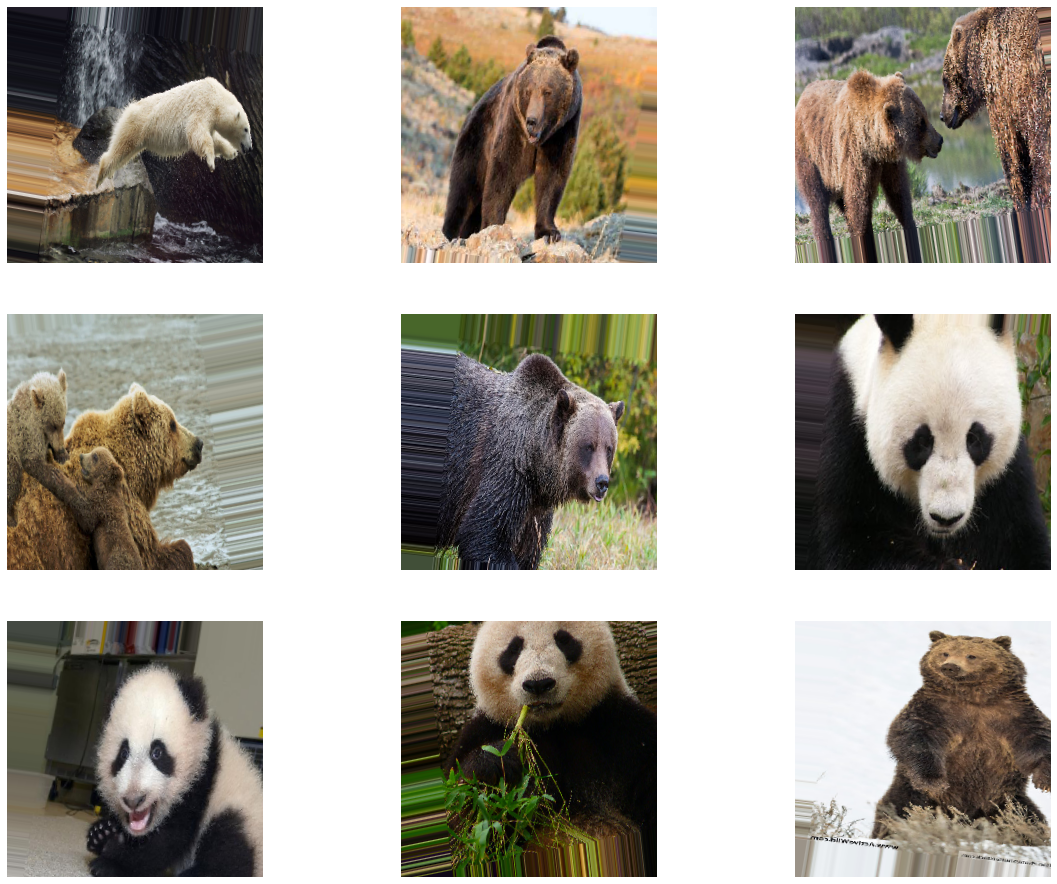

In [ ]:
L = 3
plt.figure(figsize=(20,16))
for my_batch in augmented_training:
  images = my_batch[0]
  labels = my_batch[1]
  for r in range(0,3):
    for c in range(0,3):
      plt.subplot(L,L,r * L + c + 1)
      plt.axis('off')
      #plt.title(labels[r * L + c])
      plt.imshow(images[r * L + c])
  break

In [ ]:
model_1.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
augmented_model_history = model_1.fit( augmented_training, validation_data = augmented_validation, epochs = 50, batch_size = 64, callbacks = [callback_earlystp] )

Epoch 1/50
81/81 [==============================] - 70s 470ms/step - loss: 1.0595 - accuracy: 0.4199 - precision: 0.2644 - recall: 0.0022 - val_loss: 0.9714 - val_accuracy: 0.5967 - val_precision: 1.0000 - val_recall: 0.0123
Epoch 2/50
81/81 [==============================] - 36s 452ms/step - loss: 0.9392 - accuracy: 0.5791 - precision: 0.7247 - recall: 0.1209 - val_loss: 0.8595 - val_accuracy: 0.5885 - val_precision: 0.7214 - val_recall: 0.4156
Epoch 3/50
81/81 [==============================] - 35s 441ms/step - loss: 0.7398 - accuracy: 0.6825 - precision: 0.7858 - recall: 0.5292 - val_loss: 0.7856 - val_accuracy: 0.6173 - val_precision: 0.6957 - val_recall: 0.5267
Epoch 4/50
81/81 [==============================] - 36s 447ms/step - loss: 0.7397 - accuracy: 0.6690 - precision: 0.7536 - recall: 0.5772 - val_loss: 0.7579 - val_accuracy: 0.6790 - val_precision: 0.7660 - val_recall: 0.5926
Epoch 5/50
81/81 [==============================] - 36s 447ms/step - loss: 0.6580 - accuracy: 0.7313

In [ ]:
plt.subplots_adjust(right=1.95, left=.03)

plt.subplot(1,3,1)
plt.plot(augmented_model_history.history['accuracy'])
plt.plot(augmented_model_history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(augmented_model_history.history['precision'])
plt.plot(augmented_model_history.history['val_precision'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
#plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,3)
plt.plot(augmented_model_history.history['recall'])
plt.plot(augmented_model_history.history['val_recall'])
plt.ylabel('Recall')
plt.xlabel('')
#plt.legend(['training','validation'], loc="lower right")

plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall = model_1.evaluate(augmented_testing)

print('%s %.2f' % ('validation_acc: ', test_acc*100.0 ))
print('%s %.2f' % ('validation_loss:', test_loss ))
print('%s %.2f' % ('validation_precision:', test_precision ))
print('%s %.2f' % ('validation_recall:', test_recall ))

27/27 [==============================] - 8s 309ms/step - loss: 0.3396 - accuracy: 0.8765 - precision: 0.8889 - recall: 0.8560
validation_acc:  87.65
validation_loss: 0.34
validation_precision: 0.89
validation_recall: 0.86


In [ ]:
del model_1

**Augmentation 4**

We will next try to see how our model performs when we reduce our color channels from 3 to 1. This will test whether color is a critical feature for the model.

In [ ]:
augmented_training = augmented_generator.flow_from_directory( 'bears/training', target_size=(256, 256), batch_size=9, class_mode='categorical', color_mode='grayscale')
augmented_validation = augmented_generator.flow_from_directory( 'bears/validation', target_size=(256, 256), batch_size=9, class_mode='categorical', color_mode='grayscale')
augmented_testing = augmented_generator.flow_from_directory( 'bears/test', target_size=(256, 256), batch_size=9, class_mode='categorical', color_mode='grayscale')

Found 727 images belonging to 3 classes.
Found 243 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


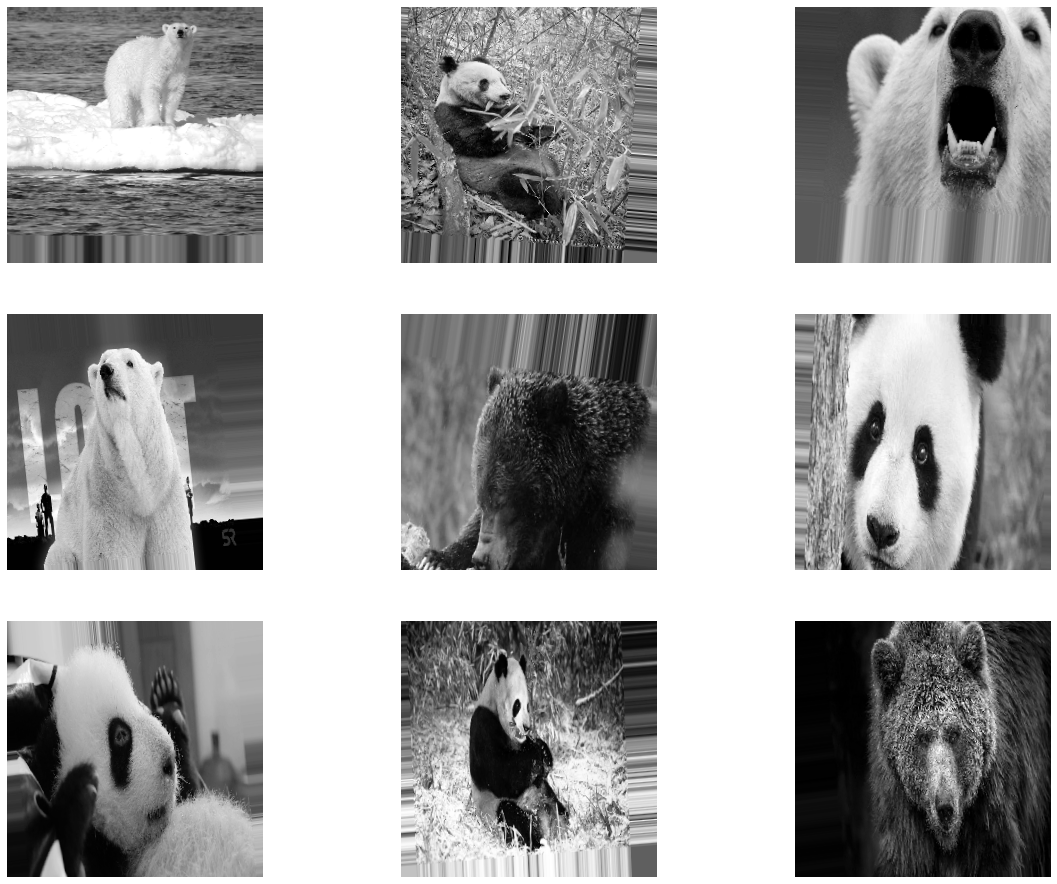

In [ ]:
L = 3
plt.figure(figsize=(20,16))
for my_batch in augmented_training:
  images = my_batch[0]
  labels = my_batch[1]
  for r in range(0,3):
    for c in range(0,3):
      plt.subplot(L,L,r * L + c + 1)
      plt.axis('off')
      #plt.title(labels[r * L + c])
      plt.imshow(np.squeeze(images[r * L + c]), cmap="gray")
  break

In [ ]:
model_1.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
augmented_model_history = model_1.fit( augmented_training, validation_data = augmented_validation, epochs = 50, batch_size = 64, callbacks = [callback_earlystp] )

Epoch 1/50
81/81 [==============================] - 31s 380ms/step - loss: 1.0841 - accuracy: 0.3439 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.0270 - val_accuracy: 0.4362 - val_precision_1: 1.0000 - val_recall_1: 0.0041
Epoch 2/50
81/81 [==============================] - 30s 378ms/step - loss: 1.0223 - accuracy: 0.4724 - precision_1: 0.5380 - recall_1: 0.0251 - val_loss: 0.9858 - val_accuracy: 0.5309 - val_precision_1: 0.5645 - val_recall_1: 0.1440
Epoch 3/50
81/81 [==============================] - 30s 378ms/step - loss: 0.9741 - accuracy: 0.5574 - precision_1: 0.5555 - recall_1: 0.1800 - val_loss: 0.9562 - val_accuracy: 0.5514 - val_precision_1: 0.6389 - val_recall_1: 0.1893
Epoch 4/50
81/81 [==============================] - 30s 375ms/step - loss: 0.9805 - accuracy: 0.5529 - precision_1: 0.6083 - recall_1: 0.1978 - val_loss: 0.9265 - val_accuracy: 0.5226 - val_precision_1: 0.5702 - val_recall_1: 0.2675
Epoch 5/50
81/81 [==============================] - 30s 377m

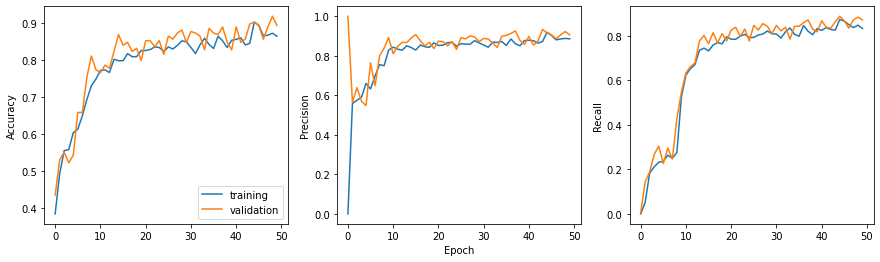

In [ ]:
plt.subplots_adjust(right=1.95, left=.03)

plt.subplot(1,3,1)
plt.plot(augmented_model_history.history['accuracy'])
plt.plot(augmented_model_history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(augmented_model_history.history['precision_1'])
plt.plot(augmented_model_history.history['val_precision_1'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
#plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,3)
plt.plot(augmented_model_history.history['recall_1'])
plt.plot(augmented_model_history.history['val_recall_1'])
plt.ylabel('Recall')
plt.xlabel('')
#plt.legend(['training','validation'], loc="lower right")

plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall = model_1.evaluate(augmented_testing)

print('%s %.2f' % ('validation_acc: ', test_acc*100.0 ))
print('%s %.2f' % ('validation_loss:', test_loss ))
print('%s %.2f' % ('validation_precision:', test_precision ))
print('%s %.2f' % ('validation_recall:', test_recall ))

27/27 [==============================] - 7s 269ms/step - loss: 0.4311 - accuracy: 0.8477 - precision_1: 0.8690 - recall_1: 0.8189
validation_acc:  84.77
validation_loss: 0.43
validation_precision: 0.87
validation_recall: 0.82


In [ ]:
del model_1

### 6. Model Regularization

We will next apply a few regularization methods (batch normalization and dropout) to see if we can improve accuracy. 

**Regularization #1**

First, we will add BatchNormalization to our best-fit model. 

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dropout

In [ ]:
model_1 = Sequential()
model_1.add( BatchNormalization())
model_1.add( Conv2D(filters=16, kernel_size=3, activation = 'relu', input_shape = training_data.image_shape ) )
model_1.add( MaxPool2D(5,5)) 
model_1.add( BatchNormalization())
model_1.add( Conv2D(filters=8, kernel_size=3, activation = 'relu' ) )
model_1.add( MaxPool2D(5,5))
model_1.add( BatchNormalization())
model_1.add( Conv2D(filters=4, kernel_size=3, activation = 'relu' ) )
model_1.add( MaxPool2D(5,5))
model_1.add( Flatten())
model_1.add( Dense(units=5, activation = 'relu' ) )
model_1.add( Dense(units=3, activation = 'softmax' ) )

In [ ]:
model_1.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
fit_history_1 = model_1.fit( training_data, validation_data = validation_data, epochs = 50, batch_size = 64, callbacks = [callback_earlystp] )

Epoch 1/50
81/81 [==============================] - 27s 319ms/step - loss: 1.1176 - accuracy: 0.3880 - precision_2: 0.3590 - recall_2: 0.0293 - val_loss: 1.1204 - val_accuracy: 0.3086 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/50
81/81 [==============================] - 25s 307ms/step - loss: 0.9541 - accuracy: 0.4929 - precision_2: 0.8080 - recall_2: 0.1600 - val_loss: 1.1740 - val_accuracy: 0.5144 - val_precision_2: 0.4000 - val_recall_2: 0.0082
Epoch 3/50
81/81 [==============================] - 25s 306ms/step - loss: 0.8102 - accuracy: 0.6810 - precision_2: 0.7960 - recall_2: 0.4301 - val_loss: 1.0802 - val_accuracy: 0.4938 - val_precision_2: 0.5808 - val_recall_2: 0.3992
Epoch 4/50
81/81 [==============================] - 25s 309ms/step - loss: 0.6802 - accuracy: 0.7586 - precision_2: 0.8160 - recall_2: 0.6550 - val_loss: 0.7704 - val_accuracy: 0.7119 - val_precision_2: 0.7290 - val_recall_2: 0.6420
Epoch 5/50
81/81 [==============================] - 25s 307m

In [ ]:
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, None, None, 3)     12        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, None, None, 16)    448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, None, None, 16)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, None, None, 16)    64        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, None, None, 8)     1160      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, None, None, 8)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, None, None, 8)    

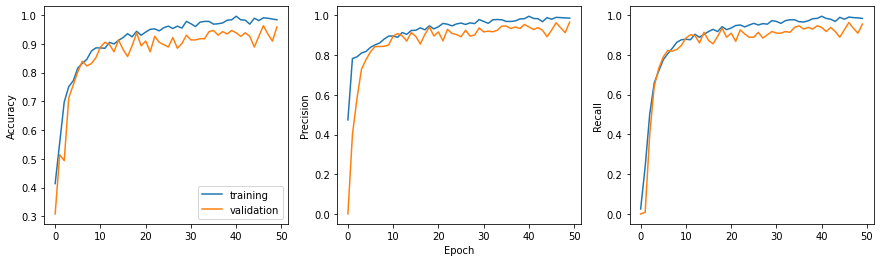

In [ ]:
plt.subplots_adjust(right=1.95, left=.03)

plt.subplot(1,3,1)
plt.plot(fit_history_1.history['accuracy'])
plt.plot(fit_history_1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(fit_history_1.history['precision_2'])
plt.plot(fit_history_1.history['val_precision_2'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
#plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,3)
plt.plot(fit_history_1.history['recall_2'])
plt.plot(fit_history_1.history['val_recall_2'])
plt.ylabel('Recall')
plt.xlabel('')
#plt.legend(['training','validation'], loc="lower right")

plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall = model_1.evaluate(testing_data)

print('%s %.2f' % ('validation_acc: ', test_acc*100.0 ))
print('%s %.2f' % ('validation_loss:', test_loss ))
print('%s %.2f' % ('validation_precision:', test_precision ))
print('%s %.2f' % ('validation_recall:', test_recall ))

27/27 [==============================] - 6s 215ms/step - loss: 0.2080 - accuracy: 0.9259 - precision_2: 0.9259 - recall_2: 0.9259
validation_acc:  92.59
validation_loss: 0.21
validation_precision: 0.93
validation_recall: 0.93


In [ ]:
del model_1

**Regularization #2**

We will next add some Dropout layers. 

In [ ]:
model_1 = Sequential()
model_1.add( Conv2D(filters=16, kernel_size=3, activation = 'relu', input_shape = training_data.image_shape ) )
model_1.add( MaxPool2D(5,5)) 
model_1.add( Dropout(rate=0.2))
model_1.add( Conv2D(filters=8, kernel_size=3, activation = 'relu' ) )
model_1.add( MaxPool2D(5,5))
model_1.add( Dropout(rate=0.2))
model_1.add( Conv2D(filters=4, kernel_size=3, activation = 'relu' ) )
model_1.add( MaxPool2D(5,5))
model_1.add( Dropout(rate=0.2))
model_1.add( Flatten())
model_1.add( Dense(units=5, activation = 'relu' ) )
model_1.add( Dense(units=3, activation = 'softmax' ) )

In [ ]:
model_1.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )

In [ ]:
fit_history_1 = model_1.fit( training_data, validation_data = validation_data, epochs = 50, batch_size = 64, callbacks = [callback_earlystp] )

Epoch 1/50
81/81 [==============================] - 26s 316ms/step - loss: 1.1321 - accuracy: 0.3396 - precision_5: 0.3057 - recall_5: 0.0416 - val_loss: 1.0959 - val_accuracy: 0.4815 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/50
81/81 [==============================] - 25s 310ms/step - loss: 1.0869 - accuracy: 0.4182 - precision_5: 0.4146 - recall_5: 7.2222e-04 - val_loss: 1.0870 - val_accuracy: 0.4938 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/50
81/81 [==============================] - 25s 308ms/step - loss: 1.0785 - accuracy: 0.4463 - precision_5: 0.0244 - recall_5: 6.7686e-05 - val_loss: 1.0712 - val_accuracy: 0.5103 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/50
81/81 [==============================] - 25s 308ms/step - loss: 1.0322 - accuracy: 0.4847 - precision_5: 0.7496 - recall_5: 0.0933 - val_loss: 1.0466 - val_accuracy: 0.5021 - val_precision_5: 0.4000 - val_recall_5: 0.0082
Epoch 5/50
81/81 [==================

In [ ]:
model_1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 48, 48, 8)         1160      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 9, 9, 8)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 9, 9, 8)           0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 7, 7, 4)          

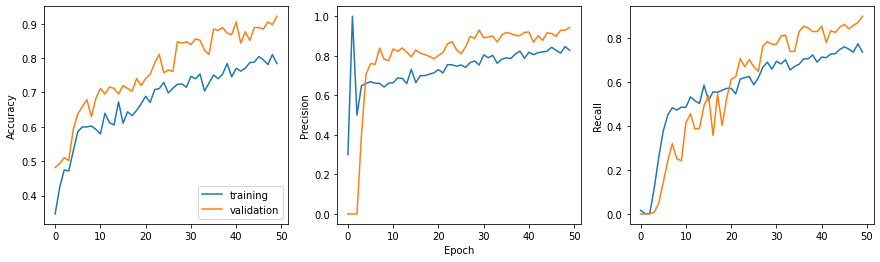

In [ ]:
plt.subplots_adjust(right=1.95, left=.03)

plt.subplot(1,3,1)
plt.plot(fit_history_1.history['accuracy'])
plt.plot(fit_history_1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(fit_history_1.history['precision_5'])
plt.plot(fit_history_1.history['val_precision_5'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
#plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,3)
plt.plot(fit_history_1.history['recall_5'])
plt.plot(fit_history_1.history['val_recall_5'])
plt.ylabel('Recall')
plt.xlabel('')
#plt.legend(['training','validation'], loc="lower right")

plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall = model_1.evaluate(testing_data)

print('%s %.2f' % ('validation_acc: ', test_acc*100.0 ))
print('%s %.2f' % ('validation_loss:', test_loss ))
print('%s %.2f' % ('validation_precision:', test_precision ))
print('%s %.2f' % ('validation_recall:', test_recall ))

27/27 [==============================] - 6s 234ms/step - loss: 0.3913 - accuracy: 0.9136 - precision_5: 0.9181 - recall_5: 0.8765
validation_acc:  91.36
validation_loss: 0.39
validation_precision: 0.92
validation_recall: 0.88


In [ ]:
del model_1

**Regularization #3**

We will next try adding some L2 regularizations.

In [ ]:
model_1 = Sequential()
model_1.add( Conv2D(filters=16, kernel_size=3, kernel_regularizer="l2", activation = 'relu', input_shape = training_data.image_shape ) )
model_1.add( MaxPool2D(5,5)) 
model_1.add( Conv2D(filters=8, kernel_size=3, kernel_regularizer="l2", activation = 'relu' ) )
model_1.add( MaxPool2D(5,5))
model_1.add( Conv2D(filters=4, kernel_size=3, kernel_regularizer="l2", activation = 'relu' ) )
model_1.add( MaxPool2D(5,5))
model_1.add( Flatten())
model_1.add( Dense(units=5, activation = 'relu' ) )
model_1.add( Dense(units=3, activation = 'softmax' ) )

In [ ]:
model_1.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
fit_history_1 = model_1.fit( training_data, validation_data = validation_data, epochs = 50, batch_size = 64, callbacks = [callback_earlystp] )

Epoch 1/50
81/81 [==============================] - 28s 334ms/step - loss: 1.2639 - accuracy: 0.3836 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 1.1751 - val_accuracy: 0.5226 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/50
81/81 [==============================] - 25s 316ms/step - loss: 1.1552 - accuracy: 0.4380 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 1.1166 - val_accuracy: 0.5309 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 3/50
81/81 [==============================] - 25s 306ms/step - loss: 1.1014 - accuracy: 0.5329 - precision_6: 0.3427 - recall_6: 0.0066 - val_loss: 1.0625 - val_accuracy: 0.5267 - val_precision_6: 0.7568 - val_recall_6: 0.1152
Epoch 4/50
81/81 [==============================] - 25s 310ms/step - loss: 1.0393 - accuracy: 0.5740 - precision_6: 0.7310 - recall_6: 0.1140 - val_loss: 0.9909 - val_accuracy: 0.5761 - val_precision_6: 0.7846 - val_recall_6: 0.2099
Epoch 5/50
81/81 [==================

In [ ]:
model_1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 48, 48, 8)         1160      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 9, 9, 8)           0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 1, 1, 4)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4)                

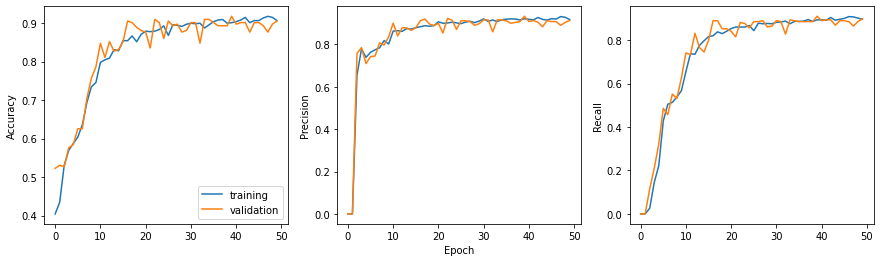

In [ ]:
plt.subplots_adjust(right=1.95, left=.03)

plt.subplot(1,3,1)
plt.plot(fit_history_1.history['accuracy'])
plt.plot(fit_history_1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(fit_history_1.history['precision_6'])
plt.plot(fit_history_1.history['val_precision_6'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
#plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,3)
plt.plot(fit_history_1.history['recall_6'])
plt.plot(fit_history_1.history['val_recall_6'])
plt.ylabel('Recall')
plt.xlabel('')
#plt.legend(['training','validation'], loc="lower right")

plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall = model_1.evaluate(testing_data)

print('%s %.2f' % ('validation_acc: ', test_acc*100.0 ))
print('%s %.2f' % ('validation_loss:', test_loss ))
print('%s %.2f' % ('validation_precision:', test_precision ))
print('%s %.2f' % ('validation_recall:', test_recall ))

27/27 [==============================] - 6s 214ms/step - loss: 0.4841 - accuracy: 0.8642 - precision_6: 0.8841 - recall_6: 0.8477
validation_acc:  86.42
validation_loss: 0.48
validation_precision: 0.88
validation_recall: 0.85


**Regularization #4**

In [ ]:
model_1 = Sequential()
model_1.add( BatchNormalization())
model_1.add( Conv2D(filters=16, kernel_size=3, activation = 'relu', input_shape = training_data.image_shape ) )
model_1.add( MaxPool2D(5,5)) 
model_1.add( Dropout(rate=0.2))
model_1.add( BatchNormalization())
model_1.add( Conv2D(filters=8, kernel_size=3, activation = 'relu' ) )
model_1.add( MaxPool2D(5,5))
model_1.add( Dropout(rate=0.2))
model_1.add( BatchNormalization())
model_1.add( Conv2D(filters=4, kernel_size=3, activation = 'relu' ) )
model_1.add( MaxPool2D(5,5))
model_1.add( Dropout(rate=0.2))
model_1.add( Flatten())
model_1.add( Dense(units=5, activation = 'relu' ) )
model_1.add( Dense(units=3, activation = 'softmax' ) )

In [ ]:
model_1.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
fit_history_1 = model_1.fit( training_data, validation_data = validation_data, epochs = 50, batch_size = 64, callbacks = [callback_earlystp] )

Epoch 1/50
81/81 [==============================] - 27s 315ms/step - loss: 1.9348 - accuracy: 0.3709 - precision: 0.3724 - recall: 0.3477 - val_loss: 1.1051 - val_accuracy: 0.3128 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
81/81 [==============================] - 25s 316ms/step - loss: 1.2090 - accuracy: 0.4144 - precision: 0.4787 - recall: 0.3072 - val_loss: 1.0754 - val_accuracy: 0.3128 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
81/81 [==============================] - 25s 311ms/step - loss: 0.9750 - accuracy: 0.5121 - precision: 0.6807 - recall: 0.3118 - val_loss: 1.0381 - val_accuracy: 0.4733 - val_precision: 1.0000 - val_recall: 0.0206
Epoch 4/50
81/81 [==============================] - 25s 311ms/step - loss: 0.8946 - accuracy: 0.5907 - precision: 0.7611 - recall: 0.3093 - val_loss: 0.9620 - val_accuracy: 0.5844 - val_precision: 0.7429 - val_recall: 0.1070
Epoch 5/50
81/81 [==============================] - 25s 313ms/step - loss: 0.8658 - 

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, None, None, 3)     12        
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 16)    448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 16)    0         
_________________________________________________________________
dropout (Dropout)            (None, None, None, 16)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 16)    64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 8)     0

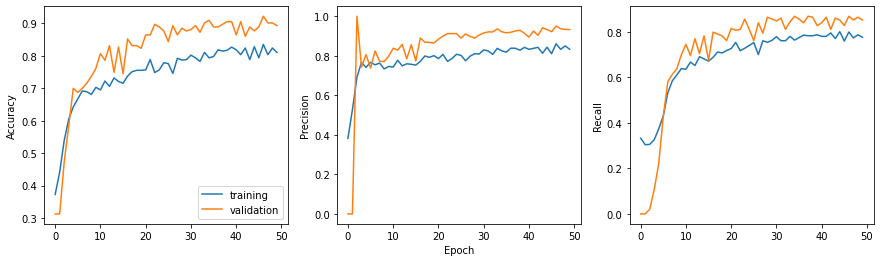

In [ ]:
plt.subplots_adjust(right=1.95, left=.03)

plt.subplot(1,3,1)
plt.plot(fit_history_1.history['accuracy'])
plt.plot(fit_history_1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(fit_history_1.history['precision'])
plt.plot(fit_history_1.history['val_precision'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
#plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,3)
plt.plot(fit_history_1.history['recall'])
plt.plot(fit_history_1.history['val_recall'])
plt.ylabel('Recall')
plt.xlabel('')
#plt.legend(['training','validation'], loc="lower right")

plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall = model_1.evaluate(testing_data)

print('%s %.2f' % ('validation_acc: ', test_acc*100.0 ))
print('%s %.2f' % ('validation_loss:', test_loss ))
print('%s %.2f' % ('validation_precision:', test_precision ))
print('%s %.2f' % ('validation_recall:', test_recall ))

27/27 [==============================] - 6s 208ms/step - loss: 0.5172 - accuracy: 0.8477 - precision: 0.8756 - recall: 0.7819
validation_acc:  84.77
validation_loss: 0.52
validation_precision: 0.88
validation_recall: 0.78


### 7. Pre-Trained Models

Our self-built model has been able to react ~92% accuracy on the test data. It may be possible for a pre-trained network to perform better. We will evaluate two existing network architectures, VGG16, ResNet50 and DenseNet201, and evaluate their performance on our data set.  

In [ ]:
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet50

We will need to load our data in again but with the default image size of 224x224 so it can be used by both networks. 

In [ ]:
image_generator = ImageDataGenerator(rescale=1./255)

training_data = image_generator.flow_from_directory( 'bears/training', target_size=(224, 224), batch_size=9, class_mode='categorical')
validation_data = image_generator.flow_from_directory( 'bears/validation', target_size=(224, 224), batch_size=9, class_mode='categorical')
testing_data = image_generator.flow_from_directory( 'bears/test', target_size=(224, 224), batch_size=9, class_mode='categorical')

Found 727 images belonging to 3 classes.
Found 243 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


**VGG16**

First, lets evaluate the VGG16 network architecture. We'll fine tune the last convolutional of the architecture by unfreezing its weights (but keep the other weights frozen) and then develop a fully-connected network to attach to the backend. 

In [ ]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [ ]:
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
import re
vgg_base.trainable = False
for layer in vgg_base.layers: 
    if bool(re.search('block5',layer.name)):
      layer.trainable = True
      print(layer.name,": Trainable")

block5_conv1 : Trainable
block5_conv2 : Trainable
block5_conv3 : Trainable
block5_pool : Trainable


In [ ]:
modelV1 = Sequential()
modelV1.add( vgg_base )
modelV1.add( Flatten() )
modelV1.add( Dense(units=25, activation = 'relu' , input_dim = 7 * 7 * 512) )
modelV1.add( Dense(units=3, activation = 'softmax' ) )
modelV1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 25)                627225    
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 78        
Total params: 15,341,991
Trainable params: 627,303
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
modelV1.compile( optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
modelV1_history = modelV1.fit( training_data, validation_data = validation_data, epochs = 50, batch_size = 64, callbacks = [callback_earlystp] )

Epoch 1/50
81/81 [==============================] - 28s 335ms/step - loss: 1.9526 - accuracy: 0.6313 - precision_4: 0.6430 - recall_4: 0.6076 - val_loss: 0.2762 - val_accuracy: 0.8765 - val_precision_4: 0.8824 - val_recall_4: 0.8642
Epoch 2/50
81/81 [==============================] - 26s 326ms/step - loss: 0.2212 - accuracy: 0.9343 - precision_4: 0.9343 - recall_4: 0.9340 - val_loss: 0.2191 - val_accuracy: 0.9383 - val_precision_4: 0.9461 - val_recall_4: 0.9383
Epoch 3/50
81/81 [==============================] - 27s 329ms/step - loss: 0.1944 - accuracy: 0.9345 - precision_4: 0.9366 - recall_4: 0.9345 - val_loss: 0.2023 - val_accuracy: 0.9383 - val_precision_4: 0.9419 - val_recall_4: 0.9342
Epoch 4/50
81/81 [==============================] - 27s 334ms/step - loss: 0.0879 - accuracy: 0.9747 - precision_4: 0.9747 - recall_4: 0.9747 - val_loss: 0.2158 - val_accuracy: 0.9588 - val_precision_4: 0.9585 - val_recall_4: 0.9506
Epoch 5/50
81/81 [==============================] - 26s 323ms/step -

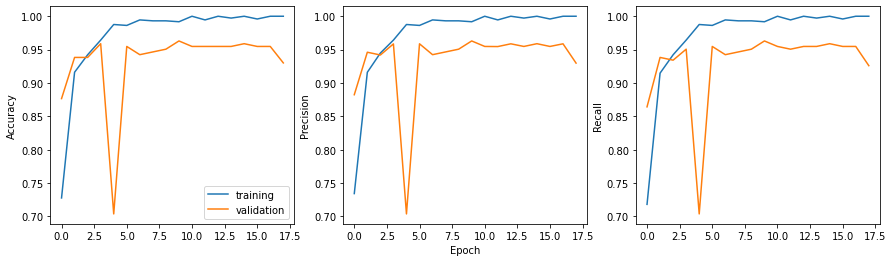

In [ ]:
plt.subplots_adjust(right=1.95, left=.03)

plt.subplot(1,3,1)
plt.plot(modelV1_history.history['accuracy'])
plt.plot(modelV1_history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(modelV1_history.history['precision_4'])
plt.plot(modelV1_history.history['val_precision_4'])
plt.ylabel('Precision')
plt.xlabel('Epoch')

plt.subplot(1,3,3)
plt.plot(modelV1_history.history['recall_4'])
plt.plot(modelV1_history.history['val_recall_4'])
plt.ylabel('Recall')
plt.xlabel('')

#plt.subplot(2,2,4)
#plt.plot(modelV1_history.history['loss'])
#plt.plot(modelV1_history.history['val_loss'])
#plt.ylabel('Loss')
#plt.xlabel('Epoch')


plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall = modelV1.evaluate(testing_data)

print('%s %.2f' % ('validation_acc: ', test_acc*100.0 ))
print('%s %.2f' % ('validation_loss:', test_loss ))
print('%s %.2f' % ('validation_precision:', test_precision ))
print('%s %.2f' % ('validation_recall:', test_recall ))

27/27 [==============================] - 6s 225ms/step - loss: 0.3475 - accuracy: 0.9300 - precision_4: 0.9300 - recall_4: 0.9300
validation_acc:  93.00
validation_loss: 0.35
validation_precision: 0.93
validation_recall: 0.93


**DenseNet121**

We will now try a more recent architecture, DenseNet121. DenseNet121 was chosen as it has equitable performance with the other DenseNet architectures available in Keras while having the fewest parameters. Like the VGG16 network, we will unfreeze the weights of the last convolutional layer. Then, we will attach a similar fully-connected network to the VGG and evaluate the performance. 

In [ ]:
dense_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [ ]:
dense_base.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
import re
dense_base.trainable = False
for layer in dense_base.layers: 
    if bool(re.search('conv5',layer.name)):
      layer.trainable = True
      print(layer.name,": Trainable")

conv5_block1_0_bn : Trainable
conv5_block1_0_relu : Trainable
conv5_block1_1_conv : Trainable
conv5_block1_1_bn : Trainable
conv5_block1_1_relu : Trainable
conv5_block1_2_conv : Trainable
conv5_block1_concat : Trainable
conv5_block2_0_bn : Trainable
conv5_block2_0_relu : Trainable
conv5_block2_1_conv : Trainable
conv5_block2_1_bn : Trainable
conv5_block2_1_relu : Trainable
conv5_block2_2_conv : Trainable
conv5_block2_concat : Trainable
conv5_block3_0_bn : Trainable
conv5_block3_0_relu : Trainable
conv5_block3_1_conv : Trainable
conv5_block3_1_bn : Trainable
conv5_block3_1_relu : Trainable
conv5_block3_2_conv : Trainable
conv5_block3_concat : Trainable
conv5_block4_0_bn : Trainable
conv5_block4_0_relu : Trainable
conv5_block4_1_conv : Trainable
conv5_block4_1_bn : Trainable
conv5_block4_1_relu : Trainable
conv5_block4_2_conv : Trainable
conv5_block4_concat : Trainable
conv5_block5_0_bn : Trainable
conv5_block5_0_relu : Trainable
conv5_block5_1_conv : Trainable
conv5_block5_1_bn : Traina

In [ ]:
model_D1 = Sequential()
model_D1.add( dense_base)
model_D1.add( Flatten())
model_D1.add( Dense(units=25, activation = 'relu' , input_dim = 7 * 7 * 1920))
model_D1.add( Dense(units=3, activation = 'softmax' ) )
model_D1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_3 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1254425   
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 78        
Total params: 8,292,007
Trainable params: 1,254,503
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
model_D1.compile( optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
model_D1_history = model_D1.fit( training_data, validation_data = validation_data, epochs = 50, batch_size = 64, callbacks = [callback_earlystp] )

Epoch 1/50
81/81 [==============================] - 35s 349ms/step - loss: 4.8115 - accuracy: 0.6827 - precision_3: 0.6857 - recall_3: 0.6796 - val_loss: 0.4378 - val_accuracy: 0.9547 - val_precision_3: 0.9547 - val_recall_3: 0.9547
Epoch 2/50
81/81 [==============================] - 26s 320ms/step - loss: 0.2488 - accuracy: 0.9720 - precision_3: 0.9719 - recall_3: 0.9707 - val_loss: 0.1561 - val_accuracy: 0.9753 - val_precision_3: 0.9753 - val_recall_3: 0.9753
Epoch 3/50
81/81 [==============================] - 26s 319ms/step - loss: 0.1399 - accuracy: 0.9809 - precision_3: 0.9808 - recall_3: 0.9785 - val_loss: 0.0362 - val_accuracy: 0.9877 - val_precision_3: 0.9877 - val_recall_3: 0.9877
Epoch 4/50
81/81 [==============================] - 26s 316ms/step - loss: 0.2027 - accuracy: 0.9676 - precision_3: 0.9676 - recall_3: 0.9676 - val_loss: 0.2772 - val_accuracy: 0.9671 - val_precision_3: 0.9671 - val_recall_3: 0.9671
Epoch 5/50
81/81 [==============================] - 26s 322ms/step -

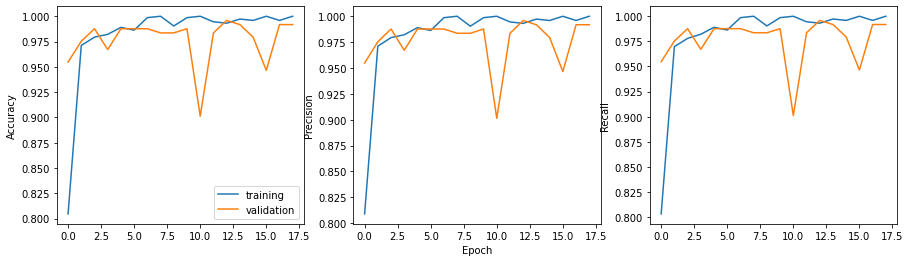

In [ ]:
plt.subplots_adjust(right=1.95, left=.005)
#plt.subplots_adjust(right=1.25,bottom=0.03, top=1.0)

plt.subplot(1,3,1)
plt.plot(model_D1_history.history['accuracy'])
plt.plot(model_D1_history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(model_D1_history.history['precision_3'])
plt.plot(model_D1_history.history['val_precision_3'])
plt.ylabel('Precision')
plt.xlabel('Epoch')

plt.subplot(1,3,3)
plt.plot(model_D1_history.history['recall_3'])
plt.plot(model_D1_history.history['val_recall_3'])
plt.ylabel('Recall')
plt.xlabel('')


plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall = model_D1.evaluate(testing_data)

print('%s %.2f' % ('validation_acc: ', test_acc*100.0 ))
print('%s %.2f' % ('validation_loss:', test_loss ))
print('%s %.2f' % ('validation_precision:', test_precision ))
print('%s %.2f' % ('validation_recall:', test_recall ))

27/27 [==============================] - 6s 227ms/step - loss: 0.0617 - accuracy: 0.9918 - precision_3: 0.9918 - recall_3: 0.9918
validation_acc:  99.18
validation_loss: 0.06
validation_precision: 0.99
validation_recall: 0.99


Between the two architectures, it appears the DenseNet121 performed far better than the VGG16, which performed only marginally better than our manually generated network. We will compare one more pre-trained model: the ResNet50.

**ResNet50**

In [ ]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
import re
resnet_base.trainable = False
for layer in resnet_base.layers: 
    if bool(re.search('conv5',layer.name)):
      layer.trainable = True
      print(layer.name,": Trainable")

conv5_block1_1_conv : Trainable
conv5_block1_1_bn : Trainable
conv5_block1_1_relu : Trainable
conv5_block1_2_conv : Trainable
conv5_block1_2_bn : Trainable
conv5_block1_2_relu : Trainable
conv5_block1_0_conv : Trainable
conv5_block1_3_conv : Trainable
conv5_block1_0_bn : Trainable
conv5_block1_3_bn : Trainable
conv5_block1_add : Trainable
conv5_block1_out : Trainable
conv5_block2_1_conv : Trainable
conv5_block2_1_bn : Trainable
conv5_block2_1_relu : Trainable
conv5_block2_2_conv : Trainable
conv5_block2_2_bn : Trainable
conv5_block2_2_relu : Trainable
conv5_block2_3_conv : Trainable
conv5_block2_3_bn : Trainable
conv5_block2_add : Trainable
conv5_block2_out : Trainable
conv5_block3_1_conv : Trainable
conv5_block3_1_bn : Trainable
conv5_block3_1_relu : Trainable
conv5_block3_2_conv : Trainable
conv5_block3_2_bn : Trainable
conv5_block3_2_relu : Trainable
conv5_block3_3_conv : Trainable
conv5_block3_3_bn : Trainable
conv5_block3_add : Trainable
conv5_block3_out : Trainable


In [ ]:
model_R1 = Sequential()
model_R1.add( resnet_base)
model_R1.add( Flatten())
model_R1.add( Dense(units=25, activation = 'relu' , input_dim = 7 * 7 * 2048))
model_R1.add( Dense(units=3, activation = 'softmax' ) )
model_R1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 25)                2508825   
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 78        
Total params: 26,096,615
Trainable params: 2,508,903
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model_R1.compile( optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = [ 'accuracy', Precision(), Recall()] )
model_R1_history = model_R1.fit( training_data, validation_data = validation_data, epochs = 50, batch_size = 64, callbacks = [callback_earlystp] )

Epoch 1/50
81/81 [==============================] - 31s 339ms/step - loss: 14.6141 - accuracy: 0.5328 - precision_5: 0.5530 - recall_5: 0.4925 - val_loss: 2.5892 - val_accuracy: 0.3292 - val_precision_5: 0.3292 - val_recall_5: 0.3292
Epoch 2/50
81/81 [==============================] - 26s 322ms/step - loss: 1.2046 - accuracy: 0.6635 - precision_5: 0.7142 - recall_5: 0.4843 - val_loss: 1.8022 - val_accuracy: 0.3457 - val_precision_5: 0.3636 - val_recall_5: 0.3457
Epoch 3/50
81/81 [==============================] - 26s 321ms/step - loss: 0.8807 - accuracy: 0.6979 - precision_5: 0.8121 - recall_5: 0.6308 - val_loss: 5.4017 - val_accuracy: 0.3498 - val_precision_5: 0.3602 - val_recall_5: 0.3498
Epoch 4/50
81/81 [==============================] - 26s 325ms/step - loss: 1.1895 - accuracy: 0.6991 - precision_5: 0.7923 - recall_5: 0.6408 - val_loss: 1.4986 - val_accuracy: 0.5514 - val_precision_5: 0.5523 - val_recall_5: 0.5432
Epoch 5/50
81/81 [==============================] - 26s 325ms/step 

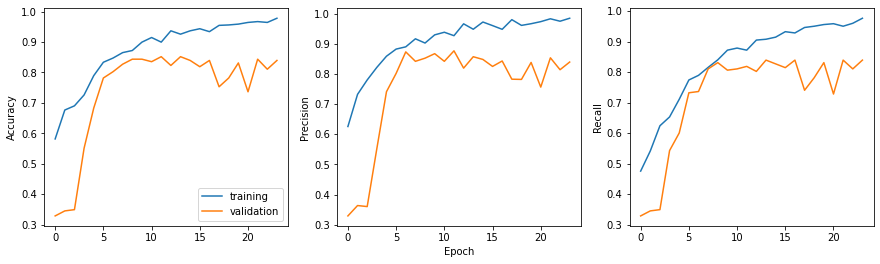

In [ ]:
plt.subplots_adjust(right=1.95, left=.03)
#plt.subplots_adjust(right=1.25,bottom=0.03, top=1.0)

plt.subplot(1,3,1)
plt.plot(model_R1_history.history['accuracy'])
plt.plot(model_R1_history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('')
plt.legend(['training','validation'], loc="lower right")

plt.subplot(1,3,2)
plt.plot(model_R1_history.history['precision_5'])
plt.plot(model_R1_history.history['val_precision_5'])
plt.ylabel('Precision')
plt.xlabel('Epoch')

plt.subplot(1,3,3)
plt.plot(model_R1_history.history['recall_5'])
plt.plot(model_R1_history.history['val_recall_5'])
plt.ylabel('Recall')
plt.xlabel('')

plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall = model_R1.evaluate(testing_data)

print('%s %.2f' % ('validation_acc: ', test_acc*100.0 ))
print('%s %.2f' % ('validation_loss:', test_loss ))
print('%s %.2f' % ('validation_precision:', test_precision ))
print('%s %.2f' % ('validation_recall:', test_recall ))

27/27 [==============================] - 6s 231ms/step - loss: 3.3572 - accuracy: 0.7737 - precision_5: 0.7737 - recall_5: 0.7737
validation_acc:  77.37
validation_loss: 3.36
validation_precision: 0.77
validation_recall: 0.77


Compared to both the VGG16 and DenseNet121 networks, the ResNet50 has appeared to overfit the data when given the same fully connected network as the other two.